### 📘 Introdução

Este notebook tem como objetivo realizar uma análise exploratória dos dados de qualidade do ar nos Estados Unidos, com foco nos principais gases poluentes monitorados pela EPA (Environmental Protection Agency) durante o ano de 2024.

Foram utilizadas as bases diárias disponibilizadas publicamente pela EPA, referentes aos seguintes poluentes atmosféricos:

- **44201** – Ozônio (Ozone)  
- **42101** – Monóxido de Carbono (Carbon Monoxide)  
- **42401** – Dióxido de Enxofre (Sulfur Dioxide)  
- **42602** – Dióxido de Nitrogênio (Nitrogen Dioxide)

Durante o processo, foram realizadas as seguintes etapas:

- 🧹 **Limpeza dos dados**, com substituição ou remoção de valores ausentes.
- 🔄 **Unificação** das bases em um único dataframe.
- 📊 **Geração de gráficos** e visualizações para identificar padrões e tendências.
- 🌎 **Mapas interativos**, para entender a distribuição geográfica dos poluentes.
- 📈 **Agrupamentos e análises temporais**, como médias por mês e por estado.
- 💡 **Classificação da qualidade do ar (AQI)** conforme faixas reconhecidas internacionalmente.

O trabalho busca fornecer insights relevantes sobre a poluição atmosférica nos EUA, com ênfase na variação ao longo do tempo, impactos regionais e características espeíficas de cada gás.
ências observadas.
 

### 🧪 Início da Análise

A seguir, serão carregadas as bibliotecas necessárias e os arquivos CSV contendo os dados de qualidade do ar. Em seguida, será feita uma análise exploratória das informações disponíveis em cada bas.


In [ ]:
#Instalando as bibliotecas necessárias
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install plotly
!pip install -U kaleido

#Importando as bibliotecas
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
import warnings
import sklearn as sl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
#Carregando as bases em dataframes individuais
df44201 = pd.read_csv("../data/daily_44201_2024.csv", low_memory=False)
df42101 = pd.read_csv("../data/daily_42101_2024.csv", low_memory=False)
df42401 = pd.read_csv("../data/daily_42401_2024.csv", low_memory=False)
df42602 = pd.read_csv("../data/daily_42602_2024.csv", low_memory=False)

#Configurando para exibir todas as colunas
pd.set_option("display.max_columns", None)

### 🧹 Início da Limpeza dos Dados – Gás 44201 (Ozônio)

In [ ]:
#Lendo o número de linhas e colunas
df44201.shape

In [ ]:
#Exibindo cinco amostras aleatórias
df44201.sample(5)

In [ ]:
#Exibindo informações gerais
df44201.info()

In [ ]:
#Exibindo estatísticas das colunas numéricas
df44201[["Observation Count","Observation Percent", "Arithmetic Mean", "1st Max Value", "1st Max Hour", "AQI"]].describe()

In [ ]:
#Exibindo valores nulos por coluna
df44201.isnull().sum()

In [ ]:
#Exibindo linha onde AQI é nulo 
df44201[df44201["AQI"].isnull()]

### 🧩 Chave da Leitura

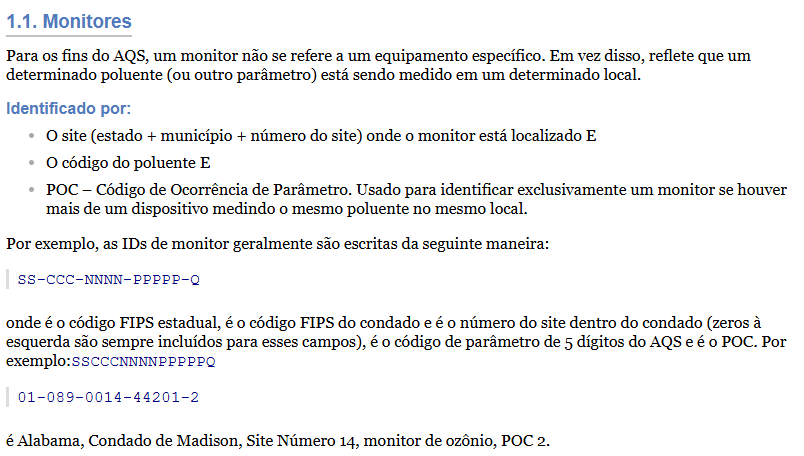

- A **chave da leitura** é composta pela combinação das seguintes colunas:
  - `State Code`
  - `County Code`
  - `Site Num`
  - `Parameter Code`
  - `POC`

- Por esse motivo, **faz sentido utilizar a média baseada nessa chave** para preencher valores ausentes, como no caso da coluna AQI.

🔗 Fonte: [EPA AirData File Formats](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html)


In [ ]:
#Buscando a média AQI da chave State Code + County Code + Site Num + Paramater Code + POC

#Selecionando os nomes das 5 primeiras colunas
colunas_chave = df44201.columns[:5].tolist()

#Agrupando pelos valores das 5 primeiras colunas e calcular a média do AQI
df_aqi_media_chave = df44201.groupby(colunas_chave)["AQI"].mean().reset_index()

#Renomeando a coluna da média do AQI
df_aqi_media_chave.rename(columns={"AQI": "Média AQI Chave"}, inplace=True)

df_aqi_media_chave

In [ ]:
#Preenchendo AQI null com a média AQI chave

#Realizar left join com base nas 5 primeiras colunas (chave)
df44201 = df44201.merge(df_aqi_media_chave, on=colunas_chave, how="left")

#Preencher valores nulos de AQI com a média calculada
df44201["AQI"].fillna(df44201["Média AQI Chave"], inplace=True)

#Remover a coluna auxiliar "Média AQI"
df44201.drop(columns=["Média AQI Chave"], inplace=True)

In [ ]:
#Exibindo valores nulos por coluna
df44201.isnull().sum()

In [ ]:
#Verificando se Method Code e Method Name tem a mesma quantidade de valores únicos
print("Valores únicos em Method Code:", df44201["Method Code"].nunique())
print("Valores únicos em Method Name:", df44201["Method Name"].nunique())

In [ ]:
#Exibindo linhas onde Method Code é nulo para ver o valor de Method Name  
df44201[df44201["Method Code"].isnull()][["Method Code", "Method Name"]]

In [ ]:
#Calculando a média de AQI para cada Method Code e Method Name  
df44201.groupby(["Method Code", "Method Name"])["AQI"].mean().sort_values(ascending=False)

In [ ]:
#Exibindo linhas onde Method Code é nulo para ver o valor de AQI
df44201[df44201["Method Code"].isnull()]

In [ ]:
#Excluindo as linhas onde Method Code é nulo, visto que não se encaixa em nenhuma categoria
df44201 = df44201.dropna(subset=["Method Code"])

In [ ]:
#Valores nulos por coluna
df44201.isnull().sum()

### 🧹 Resumo da Limpeza dos Dados – Gás 44201 (Ozônio)

- Foi identificado **um único valor ausente na coluna AQI**.
- Esse valor foi **substituído pela média de AQI**, considerando a combinação das colunas:
  - `State Code`
  - `County Code`
  - `Site Num`
  - `Parameter Code`
  - `POC`
- Também foram encontradas **3 linhas com valores ausentes nas colunas Method Code/Name**.
  - Como **não foi identificado um padrão consistente** para preenchimento, essas linhas foram **removidas do conjunto d dados**.


### 🧹 Início da Limpeza dos Dados – Gás 42101 (Monóxido de Carbono)

In [ ]:
#Lendo o número de linhas e colunas
df42101.shape

In [ ]:
#Exibindo cinco amostras aleatórias
df42101.sample(5)

In [ ]:
#Exibindo informações gerais
df42101.info()

In [ ]:
#Exibindo estatísticas das colunas numéricas
df42101[["Observation Count","Observation Percent", "Arithmetic Mean", "1st Max Value", "1st Max Hour", "AQI"]].describe()

In [ ]:
#Exibindo valores nulos por coluna
df42101.isnull().sum()

In [ ]:
#Exibindo valores ausentes de AQI por estado
df42101[df42101["AQI"].isnull()]["State Name"].value_counts()

In [ ]:
#Convertendo a coluna de data
df42101["Date Local"] = pd.to_datetime(df42101["Date Local"])

#Exibindo valores ausentes de AQI por mês
df42101[df42101["AQI"].isnull()]["Date Local"].dt.to_period("M").value_counts().sort_index()

In [ ]:
#Buscando a média AQI da chave State Code + County Code + Site Num + Paramater Code + POC

#Selecionar os nomes das 5 primeiras colunas
colunas_chave = df42101.columns[:5].tolist()

#Agrupar pelos valores das 5 primeiras colunas e calcular a média do AQI
df_aqi_media_chave = df42101.groupby(colunas_chave)["AQI"].mean().reset_index()

#Renomear a coluna da média do AQI
df_aqi_media_chave.rename(columns={"AQI": "Média AQI Chave"}, inplace=True)

df_aqi_media_chave

In [ ]:
#Preenchendo AQI null com a média AQI chave

#Realizar left join com base nas 5 primeiras colunas (chave)
df42101 = df42101.merge(df_aqi_media_chave, on=colunas_chave, how="left")

#Preencher valores nulos de AQI com a média calculada
df42101["AQI"].fillna(df42101["Média AQI Chave"], inplace=True)

#Remover a coluna auxiliar "Média AQI"
df42101.drop(columns=["Média AQI Chave"], inplace=True)

In [ ]:
#Exibindo valores nulos por coluna
df42101.isnull().sum()

### 🧹 Resumo da Limpeza dos Dados – Gás 42101 (Carbono)

- Foram identificadas **44.802 linhas com valores ausentes na coluna AQI**.
- As linhas em branco **não apresentaram um padrão específico**, seja por Estado ou por data.
- Esses campos foram **substituídos pela média de AQI**, considerando a combinação das colunas:
  - `State Code`
  - `County Code`
  - `Site Num`
  - `Parameter Code`
 - `POC`


### 🧹 Início da Limpeza dos Dados – Gás 42401 (Dióxido de Enxofre)

In [ ]:
#Lendo o número de linhas e colunas
df42401.shape

In [ ]:
#Exibindo cinco amostras aleatórias
df42401.sample(5)

In [ ]:
#Exibindo informações gerais
df42401.info()

In [ ]:
#Exibindo estatísticas das colunas numéricas
df42401[["Observation Count","Observation Percent", "Arithmetic Mean", "1st Max Value", "1st Max Hour", "AQI"]].describe()

In [ ]:
#Exibindo valores nulos por coluna
df42401.isnull().sum()

In [ ]:
#Valores de AQI ausentes por estado
df42401[df42401["AQI"].isnull()]["State Name"].value_counts()

In [ ]:
#Convertendo a coluna de data
df42401["Date Local"] = pd.to_datetime(df42401["Date Local"])

#Exibindo valores de AQI ausentes por mês
df42401[df42401["AQI"].isnull()]["Date Local"].dt.to_period("M").value_counts().sort_index()

In [ ]:
#Buscando a média AQI da chave State Code + County Code + Site Num + Paramater Code + POC

#Selecionar os nomes das 5 primeiras colunas
colunas_chave = df42401.columns[:5].tolist()

#Agrupar pelos valores das 5 primeiras colunas e calcular a média do AQI
df_aqi_media_chave = df42401.groupby(colunas_chave)["AQI"].mean().reset_index()

#Renomear a coluna da média do AQI
df_aqi_media_chave.rename(columns={"AQI": "Média AQI Chave"}, inplace=True)

df_aqi_media_chave

In [ ]:
#Preenchendo AQI null com a média AQI chave

#Realizar left join com base nas 5 primeiras colunas (chave)
df42401 = df42401.merge(df_aqi_media_chave, on=colunas_chave, how="left")

#Preencher valores nulos de AQI com a média calculada
df42401["AQI"].fillna(df42401["Média AQI Chave"], inplace=True)

#Remover a coluna auxiliar "Média AQI"
df42401.drop(columns=["Média AQI Chave"], inplace=True)

In [ ]:
#Exibindo valores nulos por coluna
df42401.isnull().sum()

### 🧹 Resumo da Limpeza dos Dados – Gás 42401 (Dióxido de Enxofre)

- Foram identificadas **79.712 linhas com valores ausentes na coluna AQI**.
- As ausências **não apresentavam um padrão específico**, ocorrendo em diversos estados e datas.
- Para tratamento, os valores ausentes foram **substituídos pela média de AQI**, com base na combinação das seguintes colunas:
  - `State Code`
  - `County Code`
  - `Site Num`
  - `Parameter Code`

 - `POC`


### 🧹 Início da Limpeza dos Dados – Gás 42602 (Dióxido de Nitrogênio)

In [ ]:
#Lendo o número de linhas e colunas
df42602.shape

In [ ]:
#Exibindo cinco amostras aleatórias
df42602.sample(5)

In [ ]:
#Exibindo informações gerais
df42602.info()

In [ ]:
#Exibindo estatísticas das colunas numéricas
df42602[["Observation Count","Observation Percent", "Arithmetic Mean", "1st Max Value", "1st Max Hour", "AQI"]].describe()

In [ ]:
#Exibindo valores nulos por coluna
df42602.isnull().sum()

### 🧹 Resumo da Limpeza dos Dados

Durante o processo de tratamento dos dados, foi observado que:

- Para o gás **42602 - Dióxido de Nitrogênio**, **não havia valores ausentes na coluna AQI**.

### 🔗 Concatenação das Bases

Com as bases individuais devidamente tratadas, o próximo passo é a **combinação dos dados em um único DataFrame**.

Essa etapa é essencial para permitir uma análise comparativa entre os diferentes gases monitorados, unificando todas as leituras em uma única estrutura de dados.

A concatenação facilita a aplicação de filtros, visualizações e comparações de forma mais eficiente e interada.


In [ ]:
#Juntando as quatro bases em um único DataFrame
df_combined = pd.concat([df44201, df42101, df42401, df42602], ignore_index=True)

In [ ]:
#Exibindo cinco amostras aleatórias do df44201
df_combined.isnull().sum()

In [ ]:
#Adicionando dicionário de mapeamento: Nome do estado -> Sigla para análise de gráfico de mapa
estado_para_sigla = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND",
    "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA",
    "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT",
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY"
}

#Adicionando nova coluna com a sigla
df_combined["State Abbrev"] = df_combined["State Name"].map(estado_para_sigla)

### 📊 Classificação dos Níveis de AQI

Os valores de **AQI (Índice de Qualidade do Ar)** são organizados em faixas que indicam o nível de risco à saúde da população. A classificação vai de **"Boa"** até **"Perigoso"**, conforme a tabela oficial de referência:

---

#### 🟢🟡🔴 Faixas de Classificação:

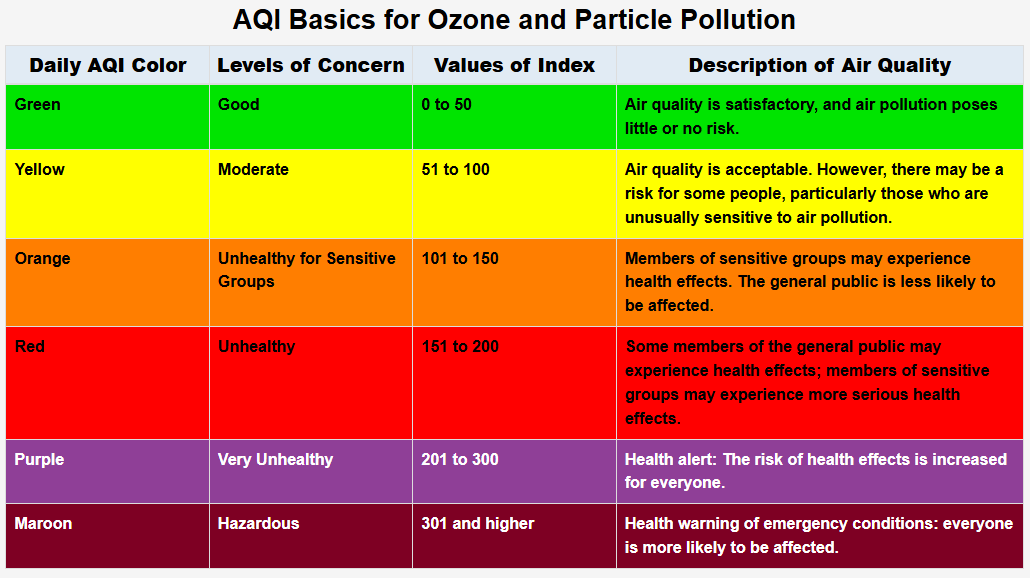

---

Essa escala é fundamental para interpretar corretamete os dados


In [ ]:
#Criando função para categorizar o AQI
def classificar_aqi(aqi):
    if aqi <= 50:
        return "Boa"
    elif aqi <= 100:
        return "Moderada"
    elif aqi <= 150:
        return "Não saudável para grupos sensíveis"
    elif aqi <= 200:
        return "Não saudável"
    elif aqi <= 300:
        return "Muito Não saudável"
    else:
        return "Perigoso"

#Criando a nova coluna com a classificação de AQI
df_combined['AQI_Classificacao'] = df_combined['AQI'].apply(classificar_aqi)

#Exibindo as primeiras linhas para conferir
df_combined[['AQI', 'AQI_Classificacao']].sample(10)

In [ ]:
#Agrupando pelo valor de classificação de AQI e contando as ocorrências
agrupado_aqi = df_combined.groupby('AQI_Classificacao').size().reset_index(name='Contagem')

#Exibindo o resultado
print(agrupado_aqi)

**Percebe-se que a maioria dos registros estão como classificação "Boa" ou "Moderada", porém possuem registros com AQI não saudável, acima de 100.**

In [ ]:
#Filtrando os dados para AQI maior que 100
df_aqi_maior_que_100 = df_combined[df_combined['AQI'] > 100]

#Agrupando por estado e contando as ocorrências
agrupado_por_estado = df_aqi_maior_que_100.groupby('State Abbrev').size().reset_index(name='Contagem')

#Ordenando os estados por contagem de ocorrências em ordem decrescente
agrupado_por_estado = agrupado_por_estado.sort_values(by='Contagem', ascending=False)

#Criando gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=agrupado_por_estado, x='State Abbrev', y='Contagem', hue='State Abbrev', palette='viridis', legend=False)

#Adicionando título e rótulos aos eixos
plt.title('Contagem de ocorrências de AQI maior que 100 (Não saudável) por Estado', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Contagem de Ocorrências', fontsize=12)

#Exibindo o gráfico
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Filtrando top 30 maiores valores de AQI
top30_aqi = df_combined.sort_values(by="AQI", ascending=False).head(30)

#Exibindo resultado
top30_aqi[["State Abbrev", "City Name", "Parameter Name", "Date Local", "AQI", "AQI_Classificacao", "Event Type"]]

### 📌 Nota sobre a Situação na Califórnia

A análise dos dados revelou alguns pontos importantes relacionados à qualidade do ar no estado da Califórnia:

---

#### 📍 Destaques:

1. **Califórnia apresenta níveis extremamente elevados de AQI**, destacando-se em relação aos demais estados.
2. O **gás Ozônio (O₃)** é o principal responsável pelos altos índices de AQI observados na região.
3. **Nenhum evento específico** foi indicado nas leituras relacionadas a essas ocorrências (coluna *Event Type* vazia).

---

Além disso, todos os registros analisados da Califórnia correspondem ao mês de **julho de 2024**, o que reforça o padrão sazonal de aumento nas concentrações de ozônio durante o verão.

---

Esses resultados reforçam a necessidade de atenção especial à Califórnia em períodos mais quentes, tanto para políticas públicas quanto para a súde da população.


In [ ]:
#Convertendo coluna de data para datetime
df_combined["Date Local"] = pd.to_datetime(df_combined["Date Local"])

#Criando coluna com o ano e mês
df_combined["AnoMes"] = df_combined["Date Local"].dt.to_period("M").astype(str)

#Listando os gases do DataFrame
gases = df_combined["Parameter Name"].unique()

#Criando 4 gráficos em uma linha
fig, axs = plt.subplots(1, 4, figsize=(16, 5))
axs = axs.flatten()

#Gerando gráfico por gás
for i, gas in enumerate(gases):
    #Filtrando por gás
    df_gas = df_combined[df_combined["Parameter Name"] == gas]
    
    #Agrupando por mês e calcular média
    aqi_por_mes = df_gas.groupby("AnoMes")["AQI"].mean().reset_index()
    
    #Plotando
    sns.lineplot(data=aqi_por_mes, x="AnoMes", y="AQI", marker="o", ax=axs[i])
    axs[i].set_title(f"Média de AQI por Mês - {gas}")
    axs[i].set_xlabel("Mês")
    axs[i].set_ylabel("AQI")
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

#Salvando o gráfico como imagem
plt.savefig("../outputs/Média AQI por mês.jpg", dpi=300, bbox_inches='tight')

#Exibindo o gráfico
plt.tight_layout()
plt.show()

### 📌 Nota sobre Comportamento Sazonal dos Poluentes

De modo geral, os dados analisados mostraram padrões sazonais consistentes com a literatura científica. Abaixo, destacam-se os principais comportamentos:

---

#### ☀️ Ozônio (O₃)

- A média de AQI do gás Ozônio atinge seu **pico no mês de julho**, considerando os dados de 2024.
- Isso ocorre porque, no verão, as temperaturas elevadas e a forte incidência solar favorecem reações fotoquímicas que aumentam a formação de ozônio ao nível do solo.
- Episódios de poluição por ozônio são mais frequentes de **junho a setembro**.

🔗 **Fonte:** [Copernicus Atmosphere Monitoring Service (CAMS)](https://atmosphere.copernicus.eu/ozone-pollution-air-quality-hazard-summer)

---

#### 🌬️ Monóxido de Carbono (CO), Dióxido de Enxofre (SO₂) e Dióxido de Nitrogênio (NO₂)

- Estes gases apresentaram seus **menores níveis de AQI durante o verão**.
- Durante esta estação, a atmosfera se torna mais instável, favorecendo a **dispersão vertical dos poluentes** e, consequentemente, reduzindo a concentração desses gases próximos ao solo.

🔗 **Fonte:** [Organização Mundial da Saúde (OMS) – WHO Global Air Quality Guidelines](https://apps.who.int/iris/bitstream/handle/10665/345329/9789240034228-eng.pdf)

---

Essas observações ajudam a compreender os padrões de poluição atmosférica e reforçam a importância do monitoramento contínuo e sazonal da qualidade do ar.
lho/24.

In [ ]:
#Selecionando os nomes das 5 primeiras colunas
colunas_chave = df_combined.columns[:5].tolist()

#Agrupando pelos valores das 5 primeiras colunas e calcular a média do AQI
df_aqi_media_chave = df_combined.groupby(colunas_chave)["AQI"].mean().reset_index()

#Renomeando a coluna da média do AQI
df_aqi_media_chave.rename(columns={"AQI": "Média AQI"}, inplace=True)

#Classificando em ordem decrescente pela média de AQI e mostrar os 20 primeiros
df_top20_aqi = df_aqi_media_chave.sort_values(by="Média AQI", ascending=False).head(20)

#Adicionando nomes
df_nomes = df_combined[[
    "State Code", "County Code", "Site Num", "Parameter Code", "State Name", "County Name", "Local Site Name", "Parameter Name"
]].drop_duplicates()

#Juntando os nomes ao dataframe agrupado
df_top20_aqi_nomeado = df_top20_aqi.merge(df_nomes, on=["State Code", "County Code", "Site Num", "Parameter Code"], how="left")

#Reordenando colunas
df_top20_aqi_nomeado = df_top20_aqi_nomeado[
    ["State Code", "State Name", "County Code", "County Name", "Site Num", "Local Site Name", "Parameter Code", "Parameter Name", "POC", "Média AQI"]]

#Exibir resultado
df_top20_aqi_nomeado.head(20)

In [ ]:
#Agrupando por estado e gás, calculando a média de AQI
aqi_por_estado_gas = df_combined.groupby(["State Abbrev", "Parameter Name"])["AQI"].mean().reset_index()

#Listando gases únicos
gases = aqi_por_estado_gas["Parameter Name"].unique()

#Gerando e salvando um gráfico para cada gás
for gas in gases:
    df_gas = aqi_por_estado_gas[aqi_por_estado_gas["Parameter Name"] == gas]

    fig = px.choropleth(
        df_gas,
        locations="State Abbrev",
        locationmode="USA-states",
        color="AQI",
        scope="usa",
        color_continuous_scale="YlOrRd",
        title=f"Média de AQI do gás {gas} por Estado nos EUA em 2024"
    )
    fig.show()
    
    #Salvando o gráfico como imagem
    fig.write_image(f"../outputs/Média AQI por Estado - {gas}.png", scale=2)  # scale=2 aumenta a qualidade

In [ ]:
#Agrupando por estado e gás, calculando a média de AQI
aqi_por_estado_gas = df_combined.groupby(["State Name", "Parameter Name"])["AQI"].mean().reset_index()

#Lista de gases únicos
gases = aqi_por_estado_gas["Parameter Name"].unique()

#Gerar um gráfico de barras para cada gás
for gas in gases:
    df_gas = aqi_por_estado_gas[aqi_por_estado_gas["Parameter Name"] == gas]

    fig = px.bar(
        df_gas.sort_values("AQI", ascending=False),
        x="State Name",
        y="AQI",
        title=f"Média de AQI do gás {gas} por Estado nos EUA em 2024",
        labels={"AQI": "Média"},
        color="AQI",
        color_continuous_scale="YlOrRd"
    )

    fig.update_layout(xaxis_title="Estado", yaxis_title="Média AQI", coloraxis_showscale=False)
    fig.show()

### 📌 Conclusão

Ao longo desta análise, foi possível compreender de forma mais aprofundada o comportamento dos principais gases poluentes monitorados nos Estados Unidos em 2024: **Ozônio (O₃)**, **Monóxido de Carbono (CO)**, **Dióxido de Enxofre (SO₂)** e **Dióxido de Nitrogênio (NO₂)**.

As análises revelaram padrões temporais bem definidos, como o **pico de concentração de Ozônio durante os meses de verão**, especialmente em julho, o que pode ser explicado pela maior radiação solar e temperaturas elevadas, que favorecem reações fotoquímicas. Por outro lado, gases como o **Monóxido de Carbono apresentaram menores níveis no verão**, sendo mais prevalentes nos meses frios, quando há maior uso de combustíveis para aquecimento.

No aspecto geográfico, estados como **Califórnia** se destacaram com **índices elevados de Ozônio**, fato que pode ser atribuído à combinação de fatores climáticos, densidade populacional e grande número de veículos.

A análise do **Índice de Qualidade do Ar (AQI)** permitiu também uma categorização das condições do ar, identificando que, apesar de muitas ocorrências estarem dentro dos limites considerados “bons” ou “moderados”, ainda há **regiões e períodos com AQI acima de 100**, indicando **níveis insalubres para grupos sensíveis**.

Esses resultados reforçam a importância do monitoramento contínuo da qualidade do ar e da formulação de políticas públicas voltadas à **redução de emissões**, especialmente em áreas urbanas e industriais. A análise também evidencia como ferramentas de ciência de dados podem contribuir significativamente para a compreensão e comunicação de temas ambientais complexos.


### 🔭 Próximos Passos

A análise realizada abre espaço para aprofundamentos futuros e complementos relevantes. Algumas sugestões de próximos passos incluem:

- **Análise multivariada**: Aplicar modelos de regressão ou técnicas como PCA para entender quais variáveis mais influenciam o AQI.
- **Modelagem preditiva**: Utilizar algoritmos de machine learning para prever o AQI com base em dados meteorológicos e históricos.
- **Correlação com dados climáticos**: Cruzar os dados de poluentes com variáveis como temperatura, umidade e velocidade do vento para melhor interpretação dos picos e quedas.
- **Séries temporais avançadas**: Investigar tendências sazonais mais profundas e possíveis padrões semanais ou horários.
- **Comparação internacional**: Repetir a análise com dados de outros países para comparar políticas ambientais e padrões de qualidade do ar.
- **Análise por grupos sensíveis**: Considerar dados populacionais para avaliar o impacto em crianças, idosos e pessoas com doenças respiratórias.

Esses caminhos podem ampliar ainda mais o valor da análise, contribuindo para políticas públicas, estudos ambientais e educação sobre saúde e qualidade do ar.
